In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

# Read and sanitize the data
df = pd.read_csv("../data/t00/data_t00.csv")
df_full = df.copy()
drop_cols = ["worker_id", "resp_worker_id", "prop_worker_id", "updated", "status", "job_id", "status", "timestamp", "rowid", "offer_dss", "offer", "offer_final"]
df = df[[col for col in df.columns if col not in drop_cols]]
df = df.dropna()

cols = [col for col in df.columns if col != "min_offer"] + ["min_offer"]

In [6]:
from core.utils.preprocessing import df_to_xydf, df_to_xy

In [83]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, BaggingRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from core.models import AcceptanceModel

x, y = df_to_xy(df)
y = y.ravel()

split = int(x.shape[0] * 0.75)
xTrain = x[:split]
yTrain = y[:split]
xTest = x[split:]
yTest = y[split:]
model = MultinomialNB()
# model = MLPClassifier((200, 200, 200), max_iter=1000, learning_rate="invscaling", batch_size=16, solver="lbfgs")

print(xTrain.shape, yTrain.shape)
model.fit(xTrain, yTrain)

(77, 64) (77,)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [84]:
yPred = model.predict(xTest)
yPred

array([50, 50, 40, 50, 50, 40, 40, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
       40, 50, 20, 50, 50, 50, 50, 50, 40])

In [85]:
yTest

array([  5,  40,  25,  50,  50,  50,  40,  50, 100,   5,  55,  45,  35,
        50,  45,  30,  50,  50,  15,  50,   5,  50,  50,  50,  50,  40])

In [86]:
from core.models.metrics import gain_mean, avg_loss_ratio
print("loss ratio: ", avg_loss_ratio(yTest, yPred))
gain_mean(yTest, yPred)

loss ratio:  0.3037609885549871


41.53846153846154

In [87]:
import numpy as np
import pandas as pd
from core.models.metrics import loss

@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss_derivable(x, offset=1,  div1=8, div2=20):
    x1 = (x + offset) / div1
    x2 = (x) / div2
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain_derivable(x):
    return 1 - loss(x)

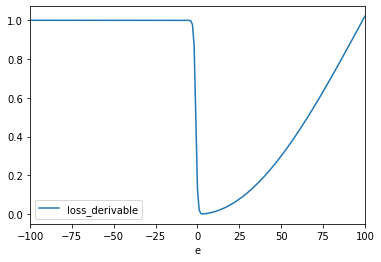

In [72]:
x = np.arange(-100, 101, 1)
y_derivable = loss_derivable(x)

out_df = pd.DataFrame({'e':x, 'loss_derivable':y_derivable})
out_df.plot.line(x='e', y='loss_derivable')

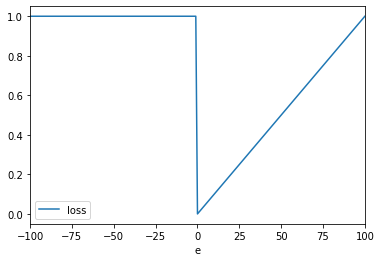

In [73]:
x = np.arange(-100, 101, 1)
y = loss(0, x) / 100

out_df = pd.DataFrame({'e':x, 'loss':y})
out_df.plot.line(x='e', y='loss')

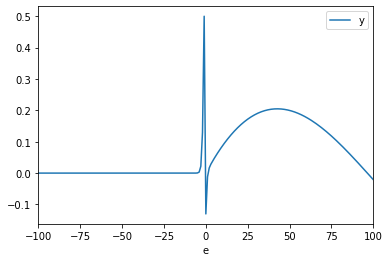

In [44]:
tmp_df = pd.DataFrame({'e':x, 'y': y - y_derivable})
tmp_df.plot.line(x='e', y='y')

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: Polyfit may be poorly conditioned
  """Entry point for launching an IPython kernel.


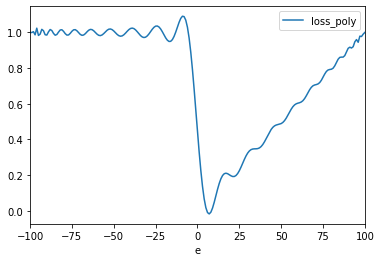

In [51]:
degs = np.polyfit(x, y, deg=150)
loss_poly = np.poly1d(degs)
y_poly = loss_poly(x)
tmp2_df = pd.DataFrame({'e':x, 'loss_poly': y_poly})
tmp2_df.plot.line(x='e', y='loss_poly')